In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import scipy as sp

sys.path.insert(1, '../')
#import reservoir and system code
from reservoir import *
from system import *

plt.style.use('seaborn')

In [2]:
def lorenz96(x, t, p):
    F = p
    D = len(x)

    dxdt = np.zeros(D)

    i = np.arange(D-1)
    dxdt[i] = (x[i+1] - x[i-2]) * x[i-1] - x[  i]
    dxdt[-1] = (x[0] - x[-3]) * x[-2] - x[-1]
    return dxdt + F # F is the forcing term

def l96jac(x, t, p):
    D = len(x)
    
    offset = [-2, -1, 0, 1]
    
    diags = []
    diags.append(-x[1:-1])
    diags.append((np.roll(x, -2) - np.roll(x, 1))[:-1])
    diags.append(-np.ones(D))
    diags.append(np.roll(x, 1)[:-1])
    
    J = sp.sparse.diags(diags, offset)
    J = J.toarray()
    
    J[-1,  0] =  x[-2]
    J[ 0, -2] = -x[-1]
    J[ 0, -1] =  x[1] - x[-2]
    J[ 1, -1] = -x[0]
    return J
    
    

D = 5

# # build the system from the dynamical equations
# # jacobian is not necessary if you do not care about the lyapunov exp
lor96sys = system(lorenz96, (8.17), D, 0.001, fjac = l96jac)

In [3]:
%%time
t, u = lor96sys.integrate(0, 20)

CPU times: user 53.3 ms, sys: 2.14 ms, total: 55.5 ms
Wall time: 55.6 ms


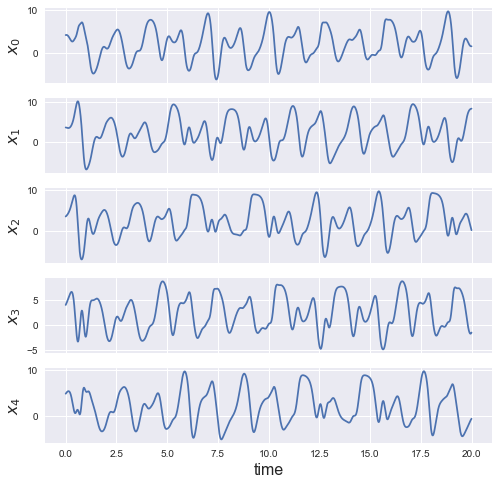

In [4]:
lor96sys.plot()

In [6]:
%%time

LE = lor96sys.globalLyap(200, 0.01)
print(np.round(LE, 3))

[ 0.686  0.01  -0.537 -1.216 -3.851]
CPU times: user 1min 11s, sys: 408 ms, total: 1min 11s
Wall time: 1min 12s


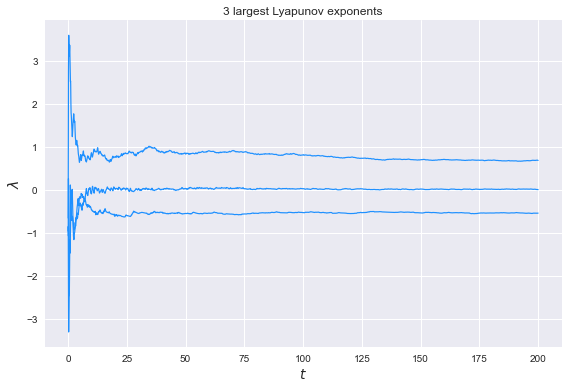

In [7]:
lor96sys.plotLE(3)

In [32]:
N = 2000
sigma = 0.1

# dr/dt = gamma * (-r + tanh(M*r+Win*u))
params = {'name': 'Lor96_N{:d}'.format(N),
          'N': N, #number of neurons
          'D': D, #dimension of the input system
          'gamma': 10, #time constant for the system
          'M_a': -1, #M connectivity matrix lower bound
          'M_b': 1, #M connectivity matrix upper bound
          'M_pnz': 0.02, #M connectivity matrix sparsity
          'M_SR': 0.9, #M connectivity matrix spectral radius
          'Win_a': -sigma, #Win input matrix lower bound
          'Win_b': sigma, #Win input matrix upper bound
          'time_step': 0.001, #integration time step for reservoir
          'spinup_time': 6, #time it takes to synchronize res with sys
          'system': lor96sys, #system to run reservoir over
          'saveplots': False} #save the plots

lor96Res = reservoir(params)

In [33]:
%%time
def Q(r): return r

train_time = 100
train_time_step = 0.02
beta = 1e-6

#takes significantly longer when get_jac = True
data = lor96Res.train(train_time, #time to train the reservoir
                      train_time_step, #time step over which to train (> integration time step)
                      Q,
                      beta,
                      get_jac = False)

CPU times: user 2min 17s, sys: 2.22 s, total: 2min 19s
Wall time: 38 s


In [34]:
lor96Res.Wout

array([[ 0.4700709 , -0.15214145, -0.5308749 , ..., -0.2955106 ,
        -0.9740881 ,  0.6346824 ],
       [ 0.37904572,  0.316028  ,  0.6489065 , ..., -0.51128626,
        -0.6109228 , -0.7353146 ],
       [ 0.6293645 , -0.67342794,  0.4774909 , ..., -0.17229486,
        -0.32394385,  0.529981  ],
       [ 1.108866  , -0.02920175,  0.34649777, ..., -0.1535412 ,
        -0.26737225, -0.08048064],
       [ 0.10061002, -0.17473412, -0.07746911, ...,  0.2931093 ,
        -0.44965196,  0.3538394 ]], dtype=float32)

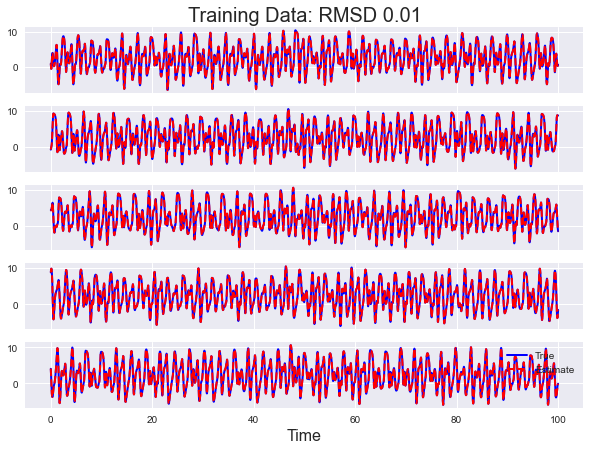

In [35]:
lor96Res.plotTraining()

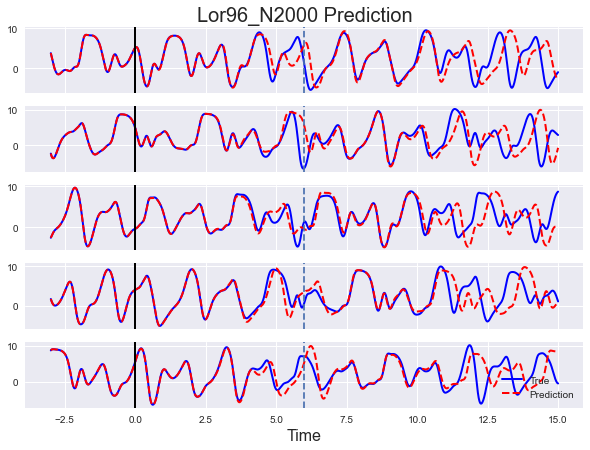

CPU times: user 12.3 s, sys: 199 ms, total: 12.5 s
Wall time: 3.76 s


In [41]:
%%time
acc = 2
pred, u_pred, u_true = lor96Res.predict(15, acc = acc, show = True, retDat = True)